<h1>XGBoost</h1>

# Introduction

XGBoost is a gradient boosting model which operates by building a series of decision trees iteratively, where each subsequent tree will try to correct the errors made by the previous tree. It uses gradient-based optimization technique to minimize the loss function.

# How XGBoost algorithm works

## 1. Calculate pseudo residuals




$Residuals = y - p$  
* $y$: Target labels
* $p$: Prediction probability  

The initial prediction probability is usually 0.5




## 2. Find the best split

XGBoost uses a metric called **Similarity Score** to choose the split when building the decision tree.  

*Similarity Score* = $\frac{∑(Residuals)^2}{∑Pi-1*(1-Pi-1) + λ}$  

* $Pi$: Previous prediction probability
* $λ$: Regularization parameter

The feature and value decided as the threshold to split the tree is the one having the highest **Gain**  

$Gain = SimilarityScore(LeftChild) + SimilarityScore(RightChild) - SimilarityScore(Root)$

## 3. Compute the output value

The value stored in leaf node are computed using the formular below

$Output = \frac{∑(Residuals)}{∑Pi-1*(1-Pi-1) + λ}$

## 4. Update prediction probability

After finishing building the tree, the prediction will be updated based on the calculated output values  

$Prediction = ln(\frac{P}{1-P}) + α*Output$

* $P$: Previous prediction probabiblity
* $Output$: The computed output value of the current tree  

The values we get from the formular above actually are log odds values. Therefore, they need to be converted to probability values

$Probability = \frac{e^{pred}}{1 + e^{pred}}$  

* $pred$: The log odds values of prediction  

Compute the residuals again with the updated probability and repeat the same steps above for subsequent models


# Implementation

In [1]:
import numpy as np
import time
import math
from sklearn.metrics import accuracy_score, log_loss
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Implement decision tree model

In [2]:
class Tree:
    def __init__(self, max_depth = 3, min_samples = 1, min_child_weight = 1, lambda_ = 0, gamma = 0):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.min_child_weight = min_child_weight
        self.lambda_ = lambda_
        self.gamma = gamma
        self.tree = {}
        self.fbs_time = 0


    #Compute the Similarity Score
    def similarity(self, residual, probs):
        nu = np.sum(residual) ** 2
        de = np.sum(probs * (1 - probs)) + self.lambda_
        return nu / de

    #Compute the output value in leaf node
    def compute_output(self, residual, probs):
        nu = np.sum(residual)
        de = np.sum(probs * (1 - probs)) + self.lambda_
        return nu / de

    def cover(self, probs):
        return np.sum(probs * (1 - probs))

    def split_data(self, X, feature_idx, split_value):
        left_idx = X[:, feature_idx] <= split_value
        right_idx = X[:, feature_idx] > split_value
        return left_idx, right_idx

    #Choose the best split based on the Gain score
    def find_best_split(self, X, residual, probs):
        best_gain = -np.inf
        best_split_feature_idx = None
        best_split_value = None

        for feature_idx in range(X.shape[1]):
            list_values = X[:, feature_idx]
            list_unique = np.unique(list_values)

            for i in range(len(list_unique) - 1):
                value = (list_unique[i] + list_unique[i + 1]) / 2

                left_idx, right_idx = self.split_data(X, feature_idx, value)
                p_left = probs[left_idx]
                p_right = probs[right_idx]

                if (len(left_idx) < self.min_samples or len(right_idx) < self.min_samples
                    or self.cover(p_left) < self.min_child_weight or self.cover(p_right) < self.min_child_weight):
                    continue

                r_left = residual[left_idx]
                r_right = residual[right_idx]

                gain = self.similarity(r_left, p_left) + self.similarity(r_right, p_right) - self.similarity(residual, probs)

                if gain > best_gain:
                    best_gain = gain
                    best_split_feature_idx = feature_idx
                    best_split_value = value

        if(best_gain - self.gamma < 0):
            best_split_feature_idx = None
            best_split_value = None

        return best_split_feature_idx, best_split_value

    def build_tree(self, X, residual, probs, depth):
        if depth >= self.max_depth or len(X) <= self.min_samples:
            return self.compute_output(residual, probs)

        start = time.time()
        split_feature_idx, split_value = self.find_best_split(X, residual, probs)
        end = time.time()
        self.fbs_time += (end - start)

        if split_feature_idx is None:
            return self.compute_output(residual, probs)

        left_idx, right_idx = self.split_data(X, split_feature_idx, split_value)
        left = self.build_tree(X[left_idx], residual[left_idx], probs[left_idx], depth + 1)
        right = self.build_tree(X[right_idx], residual[right_idx], probs[right_idx], depth + 1)

        self.tree = {
            'split_feature_idx': split_feature_idx,
            'split_value': split_value,
            'left_child': left,
            'right_child': right
        }
        return self.tree

    def get_output(self, x, tree):
        if isinstance(tree, dict):
            split_feature_idx = tree['split_feature_idx']
            split_value = tree['split_value']
            if x[split_feature_idx] <= split_value:
                return self.get_output(x, tree['left_child'])
            else:
                return self.get_output(x, tree['right_child'])
        else:
            return tree

    def fit(self, X, residual, probs):
        depth = 0
        self.tree = self.build_tree(X, residual, probs, depth)

    def predict(self, X):
        return np.array([self.get_output(x, self.tree) for x in X])

## Sequential XGBoost model

In [3]:
class XGBoost:
    def __init__(self, n_estimators, lr, lambda_ = 1e-7, gamma = 0, min_child_weight = 1, max_depth = 3):
        self.n_estimators = n_estimators
        self.lr = lr
        self.initial_pred = 0.5
        self.lambda_ = lambda_
        self.min_child_weight = min_child_weight
        self.max_depth = max_depth
        self.gamma = gamma
        self.models = []
        self.fbs_time = 0
        self.logodds_time = 0
        self.residual_time = 0
        self.predict_time = 0

    #Turn probability into log odds value
    def compute_logodds(self, p):
        return np.log(p / (1 - p))

    #Caclculate pseudo residuals
    def residual(self, y_true, y_pred):
        return (y_true - y_pred)
    
    #Change log odds value back to probability
    def compute_prob(self, logodds_p):
        return np.exp(logodds_p) / (1 + np.exp(logodds_p))

    def fit(self, X, y):
        p = np.full(len(y), self.initial_pred)

        for _ in range(self.n_estimators):
            probs = np.copy(p)
            start = time.time()
            residual = self.residual(y, p)
            end = time.time()
            self.residual_time += (end - start)

            model = Tree(lambda_ = self.lambda_, gamma = self.gamma, max_depth = self.max_depth, min_child_weight = self.min_child_weight)
            model.fit(X, residual, probs)
            self.fbs_time += model.fbs_time

            start = time.time()
            log_odds = self.compute_logodds(p)
            end = time.time()
            self.logodds_time += (end - start)

            start = time.time()
            logodds_p = log_odds + self.lr * model.predict(X)
            p = self.compute_prob(logodds_p)
            end = time.time()
            self.predict_time += (end - start)

            self.models.append(model)

    def predict_proba(self, X):
        pred = np.full(len(X), self.initial_pred)
        for model in self.models:
            logodds_p = self.compute_logodds(pred) + self.lr * model.predict(X)
            pred = np.exp(logodds_p) / (1 + np.exp(logodds_p))
        return pred

In [26]:
def extract_time_by_min_sec(time):
  minute = math.floor(time / 60)
  second = round(time % 60)
  return (minute, second)

## Load minimal data with 3000 rows and 300 rows for training and testing data respectively

In [4]:
minimal_train = np.load('train_data_3labels.npz', allow_pickle = True)
X_train = minimal_train['data']
y_train = minimal_train['label']

minimal_test = np.load('test_data_3labels.npz', allow_pickle = True)
X_test = minimal_test['data']
y_test = minimal_test['label']

## Train and evaluate the model

Since our XGBoost implementation is only able to perform binary classification at the moment, we will use the One vs Rest (OvR) strategy to deal with multiple classification problem. The OvR strategy splits the multiclass dataset into multiple binary classification problems per label. The model is then trained on each binary classfication problem and the predictions are made by choosing the label having the highest prediction probability.

### Binary classification

In [28]:
xgb_model = XGBoost(3, 0.3)
xgb_model.fit(X_train, (y_train == 0).astype(int))

y_prob_pred = xgb_model.predict_proba(X_test)

binary_labels_test = (y_test == 0).astype(int)
binary_labels_pred = (y_prob_pred > 0.5).astype(int)
accuracy = accuracy_score(binary_labels_test, binary_labels_pred)
log_loss_val = log_loss(binary_labels_test, binary_labels_pred)

print('accuracy: ', accuracy)
print('log logss: ', log_loss_val)
binary_labels_training_time = extract_time_by_min_sec(xgb_model.fbs_time)
print('fbs_time: {minute}m{second}s'.format(minute = binary_labels_training_time[0] , second = binary_labels_training_time[1]))

accuracy:  0.9466666666666667
log logss:  1.922328180752915
fbs_time: 6m11s


### Multi-classification

In [5]:
class MultiClassifier:
  def __init__(self):
    self.models = []
    self.training_time = 0

  def fit(self, X, y):
    start_time = time.time()
    for label in np.unique(y):
      binary_labels = (y == label).astype(int)
      model = XGBoost(3, 0.3)
      model.fit(X, binary_labels)
      self.models.append(model)
    end_time = time.time()
    self.training_time += (end_time - start_time)

  def predict(self, X):
    preds = []
    for model in self.models:
      preds.append(model.predict_proba(X))
    return np.argmax(preds, axis = 0)


In [6]:
multi_classifier = MultiClassifier()
multi_classifier.fit(X_train, y_train)

y_pred = multi_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('accuracy: ', accuracy)

accuracy:  0.9566666666666667
training time: 19m8s


# Training time

In [31]:
training_time_df = pd.DataFrame({'labels': ['binary_labels', 'three_labels'],
                                 'time': [xgb_model.fbs_time, multi_classifier.training_time]})
training_time_df

,labels,time
0,binary_labels,371.044043
1,three_labels,1147.678667


Text(0, 0.5, 'time (seconds)')

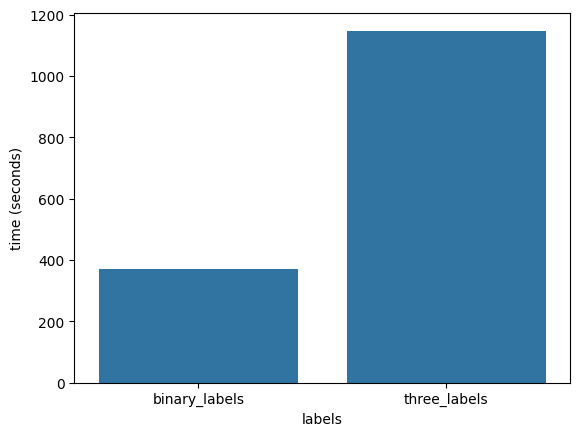

In [32]:
ax = sns.barplot(data = training_time_df, x = 'labels', y = 'time')
ax.set_ylabel('time (seconds)')